<a href="https://colab.research.google.com/github/Nancy-Shi/Complex_Networks/blob/main/Compare_Hypergraph_and_Pairwise_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import random
import math as math
from math import log
import seaborn as sns
import pandas as pd

In [2]:
def generate_degree_sequence(n, gamma, kmin):
    # Generate a random set from the power law distribution
    u = np.random.uniform(size=n)
    degrees = np.ceil((1.0 - u) ** (-1.0 / (gamma - 1.0)))

    # Adjust degrees based on the minimum and maximum degree values
    kmax = int(np.sqrt(n))
    #kmax = int(1.5*n**(1/4)) # max degree allowed is 1.5*n^(1/4)
    degrees = degrees[(degrees >= kmin) & (degrees <= kmax)].astype(int)

    # Truncate or pad the sequence to match the length specified
    if len(degrees) >= n:
        degrees = degrees[:n]
    else:
        degrees = np.concatenate((degrees, np.full(n - len(degrees), kmin)))

    return degrees.tolist()

In [3]:
def Rumor_Basic(nw, lam, alp, n_samp):
   # initialize variables
    t_max = 10000
    #n_times = 100000  # number of time points at which rho_R is recorded and averaged
    #rho_R_av = np.zeros(n_times+1)  # Initialize rho_R_av as a numpy array of zeros
    #t_sav = np.zeros(n_times+1)  # Initialize t_sav as a numpy array of zeros
    #t_sav0 = 0
    N = len(nw.nodes)
    degrees = dict(nw.degree())
    kmax = max(degrees.values())

    t_end = 0
    stifler_fractions = []  # Initialize list to store stifler fractions


    for i_samp in range(1, n_samp+1):
        t = 0
        #n_sav = 0 # an index variable that keeps track of the current position in the rho_R_av array.
        #t_sav[n_sav] = t_sav0
        #rho_R = 0
        N_rec = 0

        # Initialize states with ignorant individuals
        states = {j: 0 for j in nw.nodes()}

        # Randomly select an initial spreader node
        inf = []
        initial_node = np.random.choice(list(nw.nodes()))
        states[initial_node] = 1
        inf.append(initial_node)
        N_inf = 1
        N_e = nw.degree(initial_node)

        while N_inf != 0:
            total_rate = lam * N_e + 2 * alp * N_e
            tau = -np.log(np.random.uniform(1e-6, 1)) / total_rate
            t += tau

            # Update average rho_R at specific time points
            #while n_sav < n_times and t > t_sav[n_sav]:
            #    rho_R_av[n_sav] += rho_R
            #    n_sav += 1
            #    t_sav[n_sav] += t_max/n_times

            if t >= t_max:
                break

            # Determine which event occurs
            event = np.random.uniform()
            p1 = lam / (lam + 2 * alp)
            p2 = (lam + alp )/ (lam + 2 * alp)

            # Determine if accept selected spreader based on degree distribution
            q_deg = np.random.uniform()

            # Infection event: I + S --> 2I
            if event <= p1:
                # Select a spreader individual to spread the rumor
                inf_node = np.random.choice(inf)
                if q_deg < degrees[inf_node]/kmax:
                  # Select a random neighbor to contact
                  neighbors = list(nw.neighbors(inf_node))
                  #if len(neighbors) > 0:
                  neighbor = np.random.choice(neighbors)
                  # Check if the selected neighbor is ignorant
                  if states[neighbor] == 0:
                        states[neighbor] = 1  # ignorant neighbor becomes spreader
                        inf.append(neighbor)
                        N_inf += 1
                        N_e += nw.degree(neighbor)

            else: # Recovery
                # Select a spreader individual to recover
                rec_node = np.random.choice(inf)
                if q_deg < degrees[rec_node]/kmax:
                    # Select a random neighbor to contact
                    neighbors = list(nw.neighbors(rec_node))
                    #if len(neighbors) > 0:
                    # Recover event 1:  I + R --> 2R
                    if event <= p2:
                        neighbor = np.random.choice(neighbors)
                        if states[neighbor] == 2:
                            # Update spreader to stifler if the selected neighbor is a stifler
                            states[rec_node] = 2
                            N_inf -= 1
                            N_e -= nw.degree(rec_node)
                            inf.remove(rec_node)
                            #rho_R += (1 / N)
                            N_rec += 1

                    else: # Recovery event 2: I + I --> R + I
                        neighbor = np.random.choice(neighbors)
                        if states[neighbor] == 1:
                            # Update spreader to stifler if the selected neighbor is a spreader
                            states[rec_node] = 2
                            N_inf -= 1
                            N_e -= nw.degree(rec_node)
                            inf.remove(rec_node)
                            #rho_R += (1 / N)
                            N_rec += 1


        if N_inf == 0:
          t_end += t
          stifler_frac = N_rec / N
          stifler_fractions.append(stifler_frac)
          print(lam, N_rec, t_end, stifler_frac)

        # Reset spreader and stiflers for the next sample
        #for node, state in states.items():
        #    if state == 1 or state == 2:
        #        states[node] = 0

    # Normalize the average rho_R values by dividing by the number of samples
    #rho_R_av /= n_samp
    #t_end_av = sum(t_end)/n_samp
    #rho_R_av = rho_R_end/n_samp
    avg_stifler_frac = sum(stifler_fractions) / len(stifler_fractions)
    t_end_av = t_end/n_samp

    return avg_stifler_frac, t_end_av

0.1 2 56.17368577142404 0.005
0.1 2 68.1366633015227 0.005
0.1 2 85.62050286856856 0.005
0.1 2 94.60066468448487 0.005
0.1 2 109.26842732444524 0.005
0.1 3 157.52174574886286 0.0075
0.1 2 175.1427280285464 0.005
0.1 2 190.02190052547056 0.005
0.1 2 200.4925035133786 0.005
0.1 2 244.53365286892404 0.005
0.1 2 290.80983332166704 0.005
0.1 2 330.33292231396115 0.005
0.1 2 384.020458635729 0.005
0.1 3 406.6829949445456 0.0075
0.1 2 439.0018520320965 0.005
0.1 4 458.1366858717013 0.01
0.1 3 461.3687293363533 0.0075
0.1 2 501.893981353566 0.005
0.1 2 512.0560458571393 0.005
0.1 2 517.472749109727 0.005
0.1 3 539.3949724758353 0.0075
0.1 3 556.8570904767257 0.0075
0.1 3 583.530782523199 0.0075
0.1 3 597.3076186109049 0.0075
0.1 2 616.5408750406838 0.005
0.1 2 719.5247580815918 0.005
0.1 4 734.8953296670346 0.01
0.1 2 780.3574496500833 0.005
0.1 12 832.8449547243655 0.03
0.1 2 838.9252685756 0.005
0.1 2 872.7466412731329 0.005
0.1 3 957.4362568665227 0.0075
0.1 3 998.7219004045443 0.0075
0.1 2

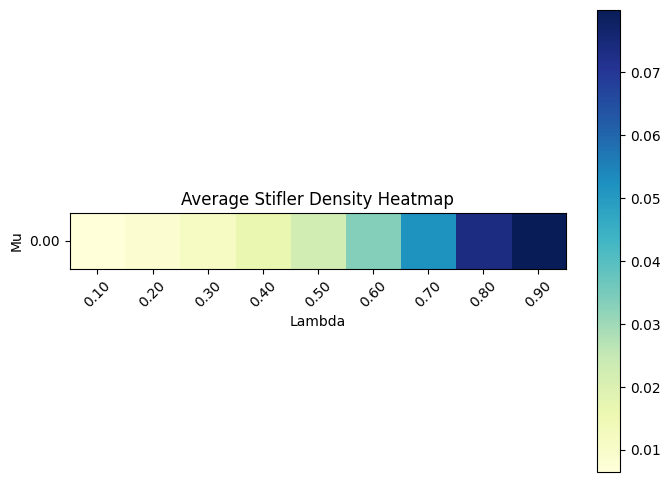

In [23]:
n= 400
gamma = 2.5
kmin = 3
degrees = generate_degree_sequence(n, gamma, kmin)
#print(degrees)
#nw = generate_configuration_model(degrees)
nw = nx.configuration_model(degrees)

alp = 1
n_samp = 100

# Set the mu and lambda_values
mu_values = np.arange(0.0, 0.1, 0.1)
lambda_values = np.arange(0.1, 1.0, 0.1)

# Initialize the result array
results = np.zeros((len(mu_values), len(lambda_values)))

# Iterate over mu and lambda values
for i, mu in enumerate(mu_values):
    for j, lam in enumerate(lambda_values):
        rho_R_av, t_end_av = Rumor_Basic(nw,  lam, alp, n_samp)
        results[i, j] = rho_R_av


import matplotlib.ticker as ticker

# Plot the heat map
fig, ax = plt.subplots(figsize=(8, 6))
heatmap = ax.imshow(results, cmap='YlGnBu', interpolation='nearest')

# Set the tick labels and show colorbar
ax.set_xticks(np.arange(len(lambda_values)))
ax.set_yticks(np.arange(len(mu_values)))

# Format the tick labels with two decimal places using string formatting
lambda_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
mu_formatter = ticker.StrMethodFormatter('{:.2f}'.format)
ax.xaxis.set_major_formatter(lambda_formatter)
ax.yaxis.set_major_formatter(mu_formatter)

ax.set_xticklabels(['{:.2f}'.format(val) for val in lambda_values])
ax.set_yticklabels(['{:.2f}'.format(val) for val in mu_values])
plt.xticks(rotation=45)

plt.colorbar(heatmap)

# Set labels and title
ax.set_xlabel('Lambda')
ax.set_ylabel('Mu')
ax.set_title('Average Stifler Density Heatmap')

# Display the heat map
plt.show()